## 1. The World Bank's international debt data
<p>No es que los humanos solo tengamos deudas para administrar nuestras necesidades. Un país también puede endeudarse para administrar su economía. Por ejemplo, el gasto en infraestructura es un ingrediente costoso requerido para que los ciudadanos de un país lleven una vida cómoda. El Banco Mundial es la organización que proporciona deuda a los países.</p>

<!-- <p>En este notebook, vamos a analizar los datos de la deuda internacional recopilados por el Banco Mundial. El conjunto de datos contiene información sobre el monto de la deuda (en USD) que deben los países en desarrollo en varias categorías.</p>  -->
  

"Disbursements on external debt, long-term (DIS, current US$)",DT.DIS.DLXF.CD
"Interest payments on external debt, long-term (INT, current US$)",DT.INT.DLXF.CD
"PPG, bilateral (AMT, current US$)",DT.AMT.BLAT.CD
"PPG, bilateral (DIS, current US$)",DT.DIS.BLAT.CD
"PPG, bilateral (INT, current US$)",DT.INT.BLAT.CD
"PPG, multilateral (AMT, current US$)",DT.AMT.MLAT.CD
"PPG, multilateral (DIS, current US$)",DT.DIS.MLAT.CD
"PPG, multilateral (INT, current US$)",DT.INT.MLAT.CD
"PPG, official creditors (AMT, current US$)",DT.AMT.OFFT.CD
"PPG, official creditors (DIS, current US$)",DT.DIS.OFFT.CD
"PPG, official creditors (INT, current US$)",DT.INT.OFFT.CD
"Principal repayments on external debt, long-term (AMT, current US$)",DT.AMT.DLXF.CD
"Interest payments on external debt, private nonguaranteed (PNG) (INT, current US$)",DT.INT.DPNG.CD
"PPG, bonds (AMT, current US$)",DT.AMT.PBND.CD
"PPG, bonds (INT, current US$)",DT.INT.PBND.CD
"PPG, commercial banks (AMT, current US$)",DT.AMT.PCBK.CD
"PPG, commercial banks (DIS, current US$)",DT.DIS.PCBK.CD
"PPG, commercial banks (INT, current US$)",DT.INT.PCBK.CD
"PPG, other private creditors (AMT, current US$)",DT.AMT.PROP.CD
"PPG, other private creditors (DIS, current US$)",DT.DIS.PROP.CD
"PPG, other private creditors (INT, current US$)",DT.INT.PROP.CD
"PPG, private creditors (AMT, current US$)",DT.AMT.PRVT.CD
"PPG, private creditors (DIS, current US$)",DT.DIS.PRVT.CD
"PPG, private creditors (INT, current US$)",DT.INT.PRVT.CD
"Principal repayments on external debt, private nonguaranteed (PNG) (AMT, current US$)",DT.AMT.DPNG.CD

<p>Vamos a encontrar las respuestas a preguntas como:

<p>¿Cuál es el monto total de la deuda que deben los países enumerados en el conjunto de datos?
<p>¿Qué país posee la cantidad máxima de deuda y cómo se ve esa cantidad?
<p>¿Cuál es el monto promedio de la deuda de los países a través de diferentes indicadores de deuda?
    
Además tenemos otro dataset en el que encontramos información histórica de algunos índices de desarrollo, entre los que se encuentran algunos de deuda como son:

Series Name,Series Code
"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN

"Central government debt, total (current LCU)",GC.DOD.TOTL.CN

"Central government debt, total (% of GDP)",GC.DOD.TOTL.GD.ZS

EJERCICIOS PRÁCTICOS:
______________________________________________________________________________________________________________


#### 1. Inicializar y cargar el contexto spark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [2]:
import urllib.request
f = urllib.request.urlretrieve ("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz", "kddcup.data_10_percent.gz")

In [3]:
from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql import SQLContext, functions as F, Row
from pyspark.sql.types import *
from pyspark.sql.types import StringType, IntegerType

# Librería para dar formato a las salidas obtenidas
import pandas as pd
import numpy as np
# Librería para aplicar expresiones regulares en el parseado
import re
# librería para parsear las fechas con formato date
from datetime import datetime
# Librería que permite descargar información de una url desde python
import urllib
from urllib.request import urlretrieve
# Librería para llamar a funciones relacionadas con el sistema operativo
import os

In [4]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

##### 2. Número de países distintos en cada dataset. Coinciden?

In [8]:
#Importar primero los 2 datasets:

#Desarrollo
url_ind_desarrollo = '/content/indicadores_desarrollo.csv'
url_ind_deuda = '/content/indicadores_deuda.csv'

#Deuda
ind_desarrollo = sc.textFile(url_ind_desarrollo)
ind_deuda = sc.textFile(url_ind_deuda)


In [9]:
ind_deuda.take(1)

['country_name,country_code,DT.AMT.BLAT.CD,DT.AMT.DLXF.CD,DT.AMT.DPNG.CD,DT.AMT.MLAT.CD,DT.AMT.OFFT.CD,DT.AMT.PBND.CD,DT.AMT.PCBK.CD,DT.AMT.PROP.CD,DT.AMT.PRVT.CD,DT.DIS.BLAT.CD,DT.DIS.DLXF.CD,DT.DIS.MLAT.CD,DT.DIS.OFFT.CD,DT.DIS.PCBK.CD,DT.DIS.PROP.CD,DT.DIS.PRVT.CD,DT.INT.BLAT.CD,DT.INT.DLXF.CD,DT.INT.DPNG.CD,DT.INT.MLAT.CD,DT.INT.OFFT.CD,DT.INT.PBND.CD,DT.INT.PCBK.CD,DT.INT.PROP.CD,DT.INT.PRVT.CD']

In [10]:
ind_desarrollo.take(1)

['country_name,country_code,anho,GC.DOD.TOTL.CN,GC.DOD.TOTL.GD.ZS,SP.DYN.CBRT.IN']

In [11]:
#QUITAR ENCABEZADOS

#Desarrollo
header_ind_desarrollo = ind_desarrollo.take(1)[0] #CONVERTIMOS LA PRIMERA FILA (HEADER) EN VALOR DE 0
ind_desarrollo =  ind_desarrollo.filter(lambda x: x != header_ind_desarrollo) #CON LA FUNCIÓN FILTER LE DECIMOS QUE DEL DATASET NOS COJA TODAS LAS FILAS DIFERENTES AL HEADER

#Deuda
header_ind_deuda = ind_deuda.take(1)[0] #CONVERTIMOS LA PRIMERA FILA (HEADER) EN VALOR DE 0
ind_deuda =  ind_deuda.filter(lambda x: x != header_ind_deuda) #CON LA FUNCIÓN FILTER LE DECIMOS QUE DEL DATASET NOS COJA TODAS LAS FILAS DIFERENTES AL HEADER

In [12]:
ind_desarrollo.take(3), ind_deuda.take(3)

(['Albania,ALB,2014 [YR2014],1023040800000,73.3202469198429,12.259',
  'Albania,ALB,2015 [YR2015],1145500940000,79.8644448747259,12.197',
  'Albania,ALB,2016 [YR2016],1188814490000,80.7355748396923,12.08'],
 ['Afghanistan,AFG,61739336.9,100847181.9,,39107845,100847181.9,,,,,49114729.4,72894453.7,23779724.3,72894453.7,,,,39903620.1,53239440.1,,13335820,53239440.1,,,,',
  'Albania,ALB,54250280.6,790248675.2,514185620,182197616.7,236447897.3,0,39445139.5,170018.4,39615157.9,76050616.1,317194512.5,234321242.3,310371858.4,4542664.9,2279989.2,6822654.1,13847333.6,165602386.9,87884000,28101536.1,41948869.7,31030688.2,4618504.3,120324.7,35769517.2',
  'Algeria,DZA,95188724.6,171185188.1,75420000,0,95188724.6,,576463.5,0,576463.5,10320772.2,10320772.2,,10320772.2,,,,7680627.6,19031728.7,3220000,8094779,15775406.6,,13192.3,23129.8,36322.1'])

In [13]:
#PARSEAMOS LOS DATOS

#Desarrollo
ind_desarrollo = ind_desarrollo.map(lambda x: x.split(",")) 

#Deuda
ind_deuda = ind_deuda.map(lambda x: x.split(",")) 

In [14]:
ind_desarrollo.take(1)

[['Albania',
  'ALB',
  '2014 [YR2014]',
  '1023040800000',
  '73.3202469198429',
  '12.259']]

In [15]:
ind_deuda.take(1)

[['Afghanistan',
  'AFG',
  '61739336.9',
  '100847181.9',
  '',
  '39107845',
  '100847181.9',
  '',
  '',
  '',
  '',
  '49114729.4',
  '72894453.7',
  '23779724.3',
  '72894453.7',
  '',
  '',
  '',
  '39903620.1',
  '53239440.1',
  '',
  '13335820',
  '53239440.1',
  '',
  '',
  '',
  '']]

In [16]:
#Elegimos los países distintos de la primera columna
paises_ind_desarrollo = ind_desarrollo.map(lambda x: x[0]).distinct()
b = paises_ind_desarrollo.count()
b

51

In [17]:
#Elegimos los países distintos de la primera columna
paises_ind_deuda = ind_deuda.map(lambda x: x[0]).distinct()
a = paises_ind_deuda.count()
a

122

In [18]:
#Realizamos la diferencia para saber los países de más que tiene un archivo sobre otro
diferencia = a - b
print('Los países en ambos archivos no coinciden por', diferencia, 'países')

Los países en ambos archivos no coinciden por 71 países


##### 3. Total de deuda contraida por cada pais: total amount of debt (in USD) DT.AMT.MLAT.CD




In [22]:
#Seleccionamos las columnas que se requieren

#otra_forma = ind_deuda.map(lambda x : [x[0], x[2]])
deuda_total_por_paises = ind_deuda.map(lambda x: [x[i] for i in [0,2]]).collect()
deuda_total_por_paises

[['Afghanistan', '61739336.9'],
 ['Albania', '54250280.6'],
 ['Algeria', '95188724.6'],
 ['Angola', '8473824016.3'],
 ['Armenia', '68968314.7'],
 ['Azerbaijan', '106369937'],
 ['Bangladesh', '386702219.8'],
 ['Belarus', '1487363278.5'],
 ['Belize', '23329498.4'],
 ['Benin', '26014505.8'],
 ['Bhutan', '189877869.8'],
 ['Bolivia', '67814879.9'],
 ['Bosnia and Herzegovina', '108704966.2'],
 ['Botswana', '7903563.5'],
 ['Brazil', '2097380010.6'],
 ['Bulgaria', '35764202.8'],
 ['Burkina Faso', '27371336'],
 ['Burundi', '10461498.5'],
 ['Cabo Verde', '11767654.3'],
 ['Cambodia', '223300273.6'],
 ['Cameroon', '9999925153.3'],
 ['Central African Republic', '8462062.9'],
 ['Chad', '82357214.9'],
 ['China', '6532446441.9'],
 ['Colombia', '447557894.1'],
 ['Comoros', '2610216'],
 ['Congo', '116452329.4'],
 ['Congo', '186071498.1'],
 ['Costa Rica', '34085176.1'],
 ["Cote d'Ivoire", '478283000.5'],
 ['Djibouti', '48803279.1'],
 ['Dominica', '8487067.1'],
 ['Dominican Republic', '214014574.6'],
 ['E

##### 4. Media de los indicadores de deuda (tabla uno): DT.AMT.BLAT.CD, DT.DIS.BLAT.CD, DT.INT.BLAT.CD

In [20]:
#Librería para poder utilizar la media
import statistics as stats 

In [21]:
indicadores_deuda = ind_deuda.map(lambda x : [x[i] for i in [0,2,11,18]])
indicadores_deuda.collect()

[['Afghanistan', '61739336.9', '49114729.4', '39903620.1'],
 ['Albania', '54250280.6', '76050616.1', '13847333.6'],
 ['Algeria', '95188724.6', '10320772.2', '7680627.6'],
 ['Angola', '8473824016.3', '8838256901.1', '1005053965.1'],
 ['Armenia', '68968314.7', '174269846.7', '24094832'],
 ['Azerbaijan', '106369937', '84748079.6', '10085950'],
 ['Bangladesh', '386702219.8', '6141785637.5', '309079773.4'],
 ['Belarus', '1487363278.5', '2265336386.7', '630234914.9'],
 ['Belize', '23329498.4', '3581448.7', '3455608.4'],
 ['Benin', '26014505.8', '334698287.3', '13208408.6'],
 ['Bhutan', '189877869.8', '95819437.4', '184064524.8'],
 ['Bolivia', '67814879.9', '554128686.3', '32609012.4'],
 ['Bosnia and Herzegovina', '108704966.2', '114375048.3', '12605397.7'],
 ['Botswana', '7903563.5', '1316332.2', '884447.5'],
 ['Brazil', '2097380010.6', '1179125278.8', '333237826.9'],
 ['Bulgaria', '35764202.8', '', '6012379.2'],
 ['Burkina Faso', '27371336', '90915960.2', '7382485.5'],
 ['Burundi', '1046149

In [23]:
#Filtramos todos los valores donde haya algún país que tenga algún valor missing
tabla = indicadores_deuda.filter(lambda x: not 'Bulgaria'  in x[0])\
                              .filter(lambda x: not 'China'  in x[0])\
                              .filter(lambda x: not 'Guinea-Bissau'  in x[0])\
                              .filter(lambda x: not 'Iran'  in x[0])\
                              .filter(lambda x: not 'Russian Federation'  in x[0])\
                              .filter(lambda x: not 'Solomon Islands'  in x[0])\
                              .filter(lambda x: not 'Somalia'  in x[0])\
                              .filter(lambda x: not 'South Africa'  in x[0])\
                              .filter(lambda x: not 'Timor-Leste'  in x[0])\
                              .filter(lambda x: not 'Tonga'  in x[0])\
                              .filter(lambda x: not 'Turkmenistan'  in x[0])\
                              .filter(lambda x: not 'Ukraine'  in x[0])

In [24]:
#Hacemos la media por columnas
media_2 = tabla.map(lambda x: (float(x[1]))).mean()
media_11 = tabla.map(lambda x: (float(x[2]))).mean()
media_18 = tabla.map(lambda x: (float(x[3]))).mean()

#Mostramos el resultado
print("The mean of column DT.AMT.BLAT.CD is" ,format(round(media_2,2)))
print("The mean of column DT.DIS.BLAT.CD is" ,format(round(media_11,2)))
print("The mean of column DT.INT.BLAT.CD is" ,format(round(media_18,2)))

The mean of column DT.AMT.BLAT.CD is 605505680.37
The mean of column DT.DIS.BLAT.CD is 1034873094.77
The mean of column DT.INT.BLAT.CD is 147938484.33


##### 5. Los 20 paises con DT.AMT.DLXF.CD más alto

In [25]:
#Seleccionamos la primera y la cuarta columna y los ordenamos de manera descendente y hacemos un take de los 20 primeros

paises_DLXF_CD = ind_deuda.map(lambda x: [x[i] for i in [0,3]]).sortBy(lambda x : x[-1], ascending = False)
paises_DLXF_CD.take(20)

[['Venezuela', '9878659207.2'],
 ["Cote d'Ivoire", '979241934.4'],
 ['Egypt', '9692114176.9'],
 ['China', '96218620835.7'],
 ['Lebanon', '9506919669.6'],
 ['South Africa', '9474257551.9'],
 ['Brazil', '90041840304.1'],
 ['Vietnam', '8873505909.2'],
 ['Macedonia', '875846538.5'],
 ['Armenia', '845630723.8'],
 ['Pakistan', '8336013891.3'],
 ['Djibouti', '83185188.3'],
 ['Timor-Leste', '825000'],
 ['Kyrgyz Republic', '816419045.1'],
 ['Ukraine', '8148995625.6'],
 ['Albania', '790248675.2'],
 ['Cambodia', '775955981.3'],
 ['Moldova', '769232867'],
 ['Togo', '73812591.8'],
 ['Guinea-Bissau', '6783629.1']]

##### 6. Pais con los datos informados todos los años.

In [26]:
#En el ejercicio 8 se puede observar que solo hay un país que cuenta con los datos del 2017, por lo que hacemos un filter

ind_desarrollo.filter(lambda x: "2017" in x[2]).collect()

[['Malawi',
  'MWI',
  '2017 [YR2017]',
  '2239858619962.69',
  '48.659564238322',
  '34.593']]

In [29]:
país = ind_desarrollo.filter(lambda x: "2017" in x[2]).map(lambda x: (x[0])).collect()
print("El país que cuenta con datos todos los años es" , format(país))

El país que cuenta con datos todos los años es ['Malawi']


##### 7. Media anual de los distintos indicadores de desarrollo

In [30]:
#Hacemos una selección de las columans que necesitamos

indicadores_desarrollo = ind_desarrollo.map(lambda x : (x[2], (float(x[3])), (float(x[4])), (float(x[5]))))
indicadores_desarrollo.collect()

[('2014 [YR2014]', 1023040800000.0, 73.3202469198429, 12.259),
 ('2015 [YR2015]', 1145500940000.0, 79.8644448747259, 12.197),
 ('2016 [YR2016]', 1188814490000.0, 80.7355748396923, 12.08),
 ('2014 [YR2014]', 674700000.0, 0.042207528166503, 13.2),
 ('2015 [YR2015]', 762718000.0, 0.0469480198522591, 12.9),
 ('2016 [YR2016]', 907555000.0, 0.054648482520169, 12.9),
 ('2014 [YR2014]', 5158420000.0, 47.2672793747079, 14.34),
 ('2015 [YR2015]', 5655150000.0, 48.1195170307089, 14.224),
 ('2016 [YR2016]', 6138814000.0, 51.4207431481606, 14.131),
 ('2014 [YR2014]', 12175704025.0, 129.629591844133, 10.916),
 ('2015 [YR2015]', 13365027241.0, 141.413895259761, 10.806),
 ('2014 [YR2014]', 19781184418.0, 24.5487262642116, 12.5),
 ('2015 [YR2015]', 33804450453.3197, 37.5981780556757, 12.5),
 ('2016 [YR2016]', 37941765765.7758, 39.960153098796, 12.4),
 ('2014 [YR2014]', 2609974000.0, 78.4811739351877, 22.067),
 ('2014 [YR2014]', 108370000000.0, 89.8206297688459, 17.965),
 ('2015 [YR2015]', 120783002000.

In [31]:
#Separamos los años por cada columna
valores_col_3 = indicadores_desarrollo.map(lambda x: (x[0], x[1]))
valores_col_4 = indicadores_desarrollo.map(lambda x: (x[0], x[2]))
valores_col_5 = indicadores_desarrollo.map(lambda x: (x[0], x[3]))

In [32]:
#Sumamos los valores por año de cada columna
suma_anual_col_3 = valores_col_3.reduceByKey(lambda a,b: a + b)
suma_anual_col_4 = valores_col_4.reduceByKey(lambda a,b: a + b)
suma_anual_col_5 = valores_col_5.reduceByKey(lambda a,b: a + b)

In [33]:
#Sumamos el número de registros(países) por año
suma_países_año = indicadores_desarrollo.map(lambda x: (x[0],1)).reduceByKey(lambda a,b: a + b)
suma_países_año.collect()

[('2014 [YR2014]', 50),
 ('2015 [YR2015]', 44),
 ('2016 [YR2016]', 39),
 ('2017 [YR2017]', 1)]

In [34]:
#Hallamos la media por variable (suma total entre número total de países)

#GC.DOD.TOTL.CN
media_3 = suma_anual_col_3.join(suma_países_año).map(lambda x:(x[0],(x[1][0]/x[1][1])))
print('La media por año de la variable GC.DOD.TOTL.CN es:')
media_3.take(4)

La media por año de la variable GC.DOD.TOTL.CN es:


[('2014 [YR2014]', 103442758732953.23),
 ('2015 [YR2015]', 131824403915902.5),
 ('2016 [YR2016]', 158813821548065.94),
 ('2017 [YR2017]', 2239858619962.69)]

In [35]:
#GC.DOD.TOTL.GD.ZS,
media_4 = suma_anual_col_4.join(suma_países_año).map(lambda x:(x[0],(x[1][0]/x[1][1])))
print('La media por año de la variable GC.DOD.TOTL.GD.ZS es:')
media_4.take(4)

La media por año de la variable GC.DOD.TOTL.GD.ZS es:


[('2014 [YR2014]', 56.843914344384395),
 ('2015 [YR2015]', 58.36559834488034),
 ('2016 [YR2016]', 58.796949624008356),
 ('2017 [YR2017]', 48.659564238322)]

In [36]:
#SP.DYN.CBRT.IN
media_5 = suma_anual_col_5.join(suma_países_año).map(lambda x:(x[0],(x[1][0]/x[1][1])))
print('La media por año de la variable SP.DYN.CBRT.IN es:')
media_5.take(4)

La media por año de la variable SP.DYN.CBRT.IN es:


[('2014 [YR2014]', 17.582620000000006),
 ('2015 [YR2015]', 16.798477272727272),
 ('2016 [YR2016]', 16.144333333333332),
 ('2017 [YR2017]', 34.593)]

##### 8. Podrías decirme el total de deuda acumulada DT.AMT.MLAT.CD por los 10 países con un valor en media menor de SP.DYN.CBRT.IN

In [37]:
# Importamos las funciones de pyspark.sql necesarias
from pyspark.sql.functions import col, avg, desc, sum

In [38]:
#Convertimos los archivos en dataframes para un mejor tratamiento

#Desarrollo
df_desarrollo = pd.read_csv(url_ind_desarrollo)
ind_desarrollo_DF = sqlContext.createDataFrame(df_desarrollo)

#Deuda
df_deuda = pd.read_csv(url_ind_deuda)
ind_deuda_DF = sqlContext.createDataFrame(df_deuda)


In [39]:
ind_desarrollo_DF.show(5)

+------------+------------+-------------+--------------+------------------+------------------+
|country_name|country_code|         anho|GC.DOD.TOTL.CN| GC.DOD.TOTL.GD.ZS|    SP.DYN.CBRT.IN|
+------------+------------+-------------+--------------+------------------+------------------+
|     Albania|         ALB|2014 [YR2014]|  1.0230408E12| 73.32024691984292|            12.259|
|     Albania|         ALB|2015 [YR2015]| 1.14550094E12|  79.8644448747259|12.197000000000001|
|     Albania|         ALB|2016 [YR2016]| 1.18881449E12| 80.73557483969229|             12.08|
|   Australia|         AUS|2014 [YR2014]|       6.747E8| 0.042207528166503|              13.2|
|   Australia|         AUS|2015 [YR2015]|     7.62718E8|0.0469480198522591|              12.9|
+------------+------------+-------------+--------------+------------------+------------------+
only showing top 5 rows



In [40]:
ind_deuda_DF.show(5)

+------------+------------+--------------+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|country_name|country_code|DT.AMT.BLAT.CD|  DT.AMT.DLXF.CD|DT.AMT.DPNG.CD|DT.AMT.MLAT.CD|DT.AMT.OFFT.CD|DT.AMT.PBND.CD|DT.AMT.PCBK.CD|DT.AMT.PROP.CD|DT.AMT.PRVT.CD|DT.DIS.BLAT.CD|  DT.DIS.DLXF.CD|DT.DIS.MLAT.CD|DT.DIS.OFFT.CD|DT.DIS.PCBK.CD|DT.DIS.PROP.CD|DT.DIS.PRVT.CD|DT.INT.BLAT.CD|DT.INT.DLXF.CD|DT.INT.DPNG.CD|DT.INT.MLAT.CD|DT.INT.OFFT.CD|DT.INT.PBND.CD|DT.INT.PCBK.CD|DT.INT.PROP.CD|DT.INT.PRVT.CD|
+------------+------------+--------------+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------

In [41]:
#Unimos ambos datasets
union_dfs = ind_desarrollo_DF.join(other=ind_deuda_DF, on=["country_name"], how="inner")
union_dfs.show(3)

+------------+------------+-------------+--------------+------------------+--------------+------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|country_name|country_code|         anho|GC.DOD.TOTL.CN| GC.DOD.TOTL.GD.ZS|SP.DYN.CBRT.IN|country_code|DT.AMT.BLAT.CD|DT.AMT.DLXF.CD|DT.AMT.DPNG.CD|DT.AMT.MLAT.CD|DT.AMT.OFFT.CD|DT.AMT.PBND.CD|DT.AMT.PCBK.CD|DT.AMT.PROP.CD|DT.AMT.PRVT.CD|DT.DIS.BLAT.CD|DT.DIS.DLXF.CD|DT.DIS.MLAT.CD|DT.DIS.OFFT.CD|DT.DIS.PCBK.CD|DT.DIS.PROP.CD|DT.DIS.PRVT.CD|DT.INT.BLAT.CD|DT.INT.DLXF.CD|DT.INT.DPNG.CD|DT.INT.MLAT.CD|DT.INT.OFFT.CD|DT.INT.PBND.CD|DT.INT.PCBK.CD|DT.INT.PROP.CD|DT.INT.PRVT.CD|
+------------+------------+-------------+-

In [42]:
# Para renombrar las columnas utilizaremos la función withColumnRenamned()
data_desarrollo = union_dfs.withColumnRenamed("anho", "year") \
    .withColumnRenamed("DT.AMT.MLAT.CD", "deuda_amount") \
    .withColumnRenamed("SP.DYN.CBRT.IN", "birth_date")

In [44]:
#Observamos el DataFrame creado con las variables que se requieren
birthday_rate = data_desarrollo.select("country_name", "deuda_amount","birth_date")
birthday_rate.show()

+------------+-------------+------------------+
|country_name| deuda_amount|        birth_date|
+------------+-------------+------------------+
| Philippines|7.390564273E8|            22.935|
|       Tonga|    2791253.2|            25.756|
|       Tonga|    2791253.2|            25.354|
|       Tonga|    2791253.2|24.976999999999997|
|      Turkey|2.932698678E9|             16.94|
|      Turkey|2.932698678E9|            16.718|
|      Turkey|2.932698678E9|            16.494|
|      Malawi| 3.56598314E7|            36.629|
|      Malawi| 3.56598314E7|            35.839|
|      Malawi| 3.56598314E7|35.163000000000004|
|      Malawi| 3.56598314E7|            34.593|
|      Jordan|2.704987155E8|25.214000000000002|
|      Jordan|2.704987155E8|            23.396|
|   Sri Lanka|4.497719611E8|            16.849|
|   Sri Lanka|4.497719611E8|            16.609|
|     Albania|1.821976167E8|            12.259|
|     Albania|1.821976167E8|12.197000000000001|
|     Albania|1.821976167E8|            

In [45]:
#Como hay países que se repiten, hacemos un groupby por país y deuda y creamos(transformamos) la columna de birth_date haciendo la media de la agrupación
birthday_rate = birthday_rate.groupBy("country_name", "deuda_amount").agg(avg("birth_date"))
birthday_rate.show()

+------------------+--------------+------------------+
|      country_name|  deuda_amount|   avg(birth_date)|
+------------------+--------------+------------------+
|       Philippines| 7.390564273E8|            22.935|
|             Tonga|     2791253.2| 25.36233333333333|
|            Turkey| 2.932698678E9|16.717333333333332|
|            Malawi|  3.56598314E7|            35.556|
|            Jordan| 2.704987155E8|            24.305|
|         Sri Lanka| 4.497719611E8|            16.729|
|           Albania| 1.821976167E8|12.178666666666667|
|              Peru|   5.5363409E8|18.564666666666668|
|         St. Lucia|  1.50192163E7|            12.502|
|           Belarus|  5.95438826E8|12.466666666666667|
|Russian Federation|    1.416695E8|13.166666666666666|
|          Thailand|  3.90715715E7|           10.9175|
|            Bhutan|  1.73904205E7|            17.791|
|           Ukraine|1.0724728303E9|              10.6|
|           Georgia| 1.440624015E8|            14.056|
|         

In [46]:
#Ordenamos por la variable de avg(birth_date) y seleccionamos 10
birthday_rate = birthday_rate.sort("avg(birth_date)").limit(10)
birthday_rate.show()

+------------------+--------------+------------------+
|      country_name|  deuda_amount|   avg(birth_date)|
+------------------+--------------+------------------+
|           Ukraine|1.0724728303E9|              10.6|
|           Moldova| 1.358428655E8|10.604333333333335|
|          Thailand|  3.90715715E7|           10.9175|
|           Albania| 1.821976167E8|12.178666666666667|
|           Belarus|  5.95438826E8|12.466666666666667|
|         St. Lucia|  1.50192163E7|            12.502|
|Russian Federation|    1.416695E8|13.166666666666666|
|           Georgia| 1.440624015E8|            14.056|
|            Brazil|2.5143187416E9|14.467666666666668|
|          Colombia|1.1009075536E9|            15.516|
+------------------+--------------+------------------+



In [47]:
#Hacemos la suma total
birthday_rate.select(sum("deuda_amount")).show()

+-----------------+
|sum(deuda_amount)|
+-----------------+
|    5.941001123E9|
+-----------------+



##### 9. ¿Hay alguna relación entre los nacimientos y el indicador DT.AMT.DLXF.CD? ¿Cómo podrías demostrarlo?

In [48]:
#Como ambas variables son numéricas, la función que más sentido tiene es realizar la correlación entre ambas variables (además de un scatterplot para visionarlo mejor)

from pyspark.ml.stat import Correlation

In [49]:
#Cambiamos el nombre de la variable para trabajar con mayor facilidad
data_9 = data_desarrollo.withColumnRenamed("DT.AMT.DLXF.CD", "deuda_amount_dlxf")

In [51]:
#Hacemos Select de las variables que necesitamos
data_selected_9 = data_9.select("birth_date", "deuda_amount_dlxf")
data_selected_9.show()

+------------------+-----------------+
|        birth_date|deuda_amount_dlxf|
+------------------+-----------------+
|            22.935|   6.4791709177E9|
|            25.756|     1.03699106E7|
|            25.354|     1.03699106E7|
|24.976999999999997|     1.03699106E7|
|             16.94| 5.15550310058E10|
|            16.718| 5.15550310058E10|
|            16.494| 5.15550310058E10|
|            36.629|     5.74223731E7|
|            35.839|     5.74223731E7|
|35.163000000000004|     5.74223731E7|
|            34.593|     5.74223731E7|
|25.214000000000002|   1.9903434792E9|
|            23.396|   1.9903434792E9|
|            16.849|   5.7614892559E9|
|            16.609|   5.7614892559E9|
|            12.259|    7.902486752E8|
|12.197000000000001|    7.902486752E8|
|             12.08|    7.902486752E8|
|            18.827|   5.8812599747E9|
|            18.544|   5.8812599747E9|
+------------------+-----------------+
only showing top 20 rows



In [52]:
#Para poder utilizar la librería de pandas es preciso convertir el DF a formato PANDAS para que pueda realizarse la operación
data_selected_9_pandas = data_selected_9.toPandas()
data_selected_9_pandas

,birth_date,deuda_amount_dlxf
0,22.935,6.479171e+09
1,25.756,1.036991e+07
2,25.354,1.036991e+07
3,24.977,1.036991e+07
4,16.940,5.155503e+10
...,...,...
69,15.515,1.198567e+10
70,15.308,1.198567e+10
71,10.759,7.692329e+08
72,10.609,7.692329e+08


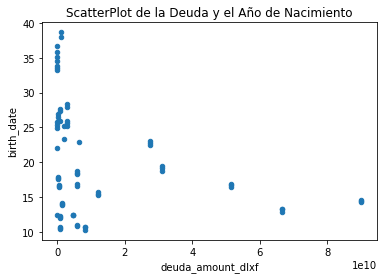

In [63]:
#Hacemos un plot de los resultados
import matplotlib.pyplot as plt

data_selected_9_pandas.plot.scatter(x="deuda_amount_dlxf", y="birth_date");
plt.xlabel('deuda_amount_dlxf') #NOMBRE EJE X
plt.ylabel('birth_date') #NOMBRE EJE Y
plt.title('ScatterPlot de la Deuda y el Año de Nacimiento'); #TÍTULO

#De primeras no se observa correlación alguna en los datos, pero realizaremos el cálculo de la correlación entre ambas variables

In [55]:
#Correlación
data_selected_9.stat.corr("deuda_amount_dlxf", "birth_date")

#La correlación es de -0.29 lo que indica que la correlación es negativa, pero es apenas representativa
#Lo que se puede afirmar que la relación entre ambas variables es prácticamente nula

-0.2974266498953495